<a href="https://colab.research.google.com/github/sidhu2690/E2E-SSL/blob/main/kanAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://cernbox.cern.ch/remote.php/dav/public-files/e3pqxcIznqdYyRv/Dataset_Specific_labelled.h5

--2024-07-17 20:06:27--  https://cernbox.cern.ch/remote.php/dav/public-files/e3pqxcIznqdYyRv/Dataset_Specific_labelled.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 137.138.120.151, 128.142.170.17, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5000042048 (4.7G) [application/octet-stream]
Saving to: 'Dataset_Specific_labelled.h5'

Dataset_Specific_la 100%[===================>]   4.66G  24.0MB/s    in 3m 11s  

2024-07-17 20:10:05 (25.0 MB/s) - 'Dataset_Specific_labelled.h5' saved [5000042048/5000042048]



In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

class ChebyshevKANLayer(torch.nn.Module):
    def __init__(self, input_dim, output_dim, degree, device):
        super(ChebyshevKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree
        self.device = device

        self.cheby_coeffs = torch.nn.Parameter(torch.empty(input_dim, output_dim, degree + 1).to(device))
        torch.nn.init.xavier_normal_(self.cheby_coeffs)
        self.register_buffer("arange", torch.arange(0, degree + 1, 1).to(device))

    def chebyshev_polynomials(self, x):
        T = [torch.ones_like(x).to(self.device), 2 * x]
        for n in range(2, self.degree + 1):
            T.append(2 * x * T[n - 1] - T[n - 2])
        return torch.stack(T, dim=-1)

    def forward(self, x):
        batch_size, seq_length, input_dim = x.size()
        x = x.view(-1, self.inputdim)
        x = torch.tanh(x)
        T = self.chebyshev_polynomials(x)
        y = torch.einsum("bij,ioj->bo", T, self.cheby_coeffs)
        y = y.view(batch_size, seq_length, self.outdim)
        return y

class MultiheadKANAttention(torch.nn.Module):
    def __init__(self, hidden_size, num_heads, rotation_matrix, degree=3, device='cpu'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.position_emb = rotation_matrix.to(device)
        self.device = device

        self.q_linear = ChebyshevKANLayer(hidden_size, hidden_size, degree, device)
        self.kv_linear = ChebyshevKANLayer(hidden_size, hidden_size * 2, degree, device)
        self.out = torch.nn.Linear(hidden_size, hidden_size).to(device)

    def forward(self, x, memory=None):
        batch_size, seq_length, _ = x.size()
        if memory is None:
            q = self.q_linear(x)
            kv = self.kv_linear(x)
            q = q.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
            kv = kv.reshape(batch_size, -1, self.num_heads, 2 * self.head_dim)
            queries = q.transpose(1, 2)
            kv = kv.transpose(1, 2)
            keys, values = kv.chunk(2, dim=-1)
        else:
            q = self.q_linear(x)
            kv = self.kv_linear(memory)
            q = q.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
            kv = kv.reshape(batch_size, -1, self.num_heads, 2 * self.head_dim)
            queries = q.transpose(1, 2)
            kv = kv.transpose(1, 2)
            keys, values = kv.chunk(2, dim=-1)

        queries = apply_rotary_pos_emb(queries, self.position_emb)
        keys = apply_rotary_pos_emb(keys, self.position_emb)

        scores = torch.matmul(queries, keys.transpose(2, 3))
        scores = scores / (self.head_dim ** 0.5)
        attention = F.softmax(scores, dim=-1)
        context = torch.matmul(attention, values)
        context = context.transpose(1, 2).contiguous()
        context = context.reshape(batch_size, seq_length, self.hidden_size)
        output = self.out(context)

        return output

class TransformerEncoderLayer(torch.nn.Module):
    def __init__(self, hidden_size, num_heads, rotation_matrix, degree=3, device='cpu'):
        super().__init__()
        self.norm1 = RMSNorm(hidden_size, device=device)
        self.attention = MultiheadKANAttention(hidden_size, num_heads, rotation_matrix, degree, device)
        self.norm2 = RMSNorm(hidden_size, device=device)
        self.ff = ChebyshevKANLayer(hidden_size, hidden_size, degree, device)

    def forward(self, x):
        x1 = self.attention(self.norm1(x))
        x = x + x1
        x2 = self.ff(self.norm2(x))
        x = x + x2
        return x

class TransformerDecoderLayer(torch.nn.Module):
    def __init__(self, hidden_size, num_heads, rotation_matrix, degree=3, device='cpu'):
        super().__init__()
        self.norm1 = RMSNorm(hidden_size, device=device)
        self.self_attention = MultiheadKANAttention(hidden_size, num_heads, rotation_matrix, degree, device)
        self.norm2 = RMSNorm(hidden_size, device=device)
        self.cross_attention = MultiheadKANAttention(hidden_size, num_heads, rotation_matrix, degree, device)
        self.norm3 = RMSNorm(hidden_size, device=device)
        self.ff = ChebyshevKANLayer(hidden_size, hidden_size, degree, device)

    def forward(self, x, enc_output):
        x1 = self.self_attention(self.norm1(x))
        x = x + x1
        x2 = self.cross_attention(self.norm2(x), enc_output)
        x = x + x2
        x3 = self.ff(self.norm3(x))
        x = x + x3
        return x

class RMSNorm(torch.nn.Module):
    def __init__(self, hidden_size: int, eps: float = 1e-6, device='cpu'):
        super().__init__()
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.ones(hidden_size).to(device))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class RotaryPositionalEmbedding(torch.nn.Module):
    def __init__(self, dim, max_seq_len, device='cpu'):
        super(RotaryPositionalEmbedding, self).__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        inv_freq = 1.0 / (1000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq.to(device))
        self.register_buffer('pos_enc', self._generate_positional_encoding(max_seq_len, device))

    def _generate_positional_encoding(self, seq_len, device):
        t = torch.arange(seq_len, device=device, dtype=self.inv_freq.dtype)
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        pos_enc = torch.cat((freqs.sin(), freqs.cos()), dim=-1)
        return pos_enc

    def forward(self, seq_len):
        return self.pos_enc[:seq_len, :]

def apply_rotary_pos_emb(x, pos_emb):
    x_cos, x_sin = torch.split(pos_emb, x.shape[-1] // 2, dim=-1)
    x1_rot = (x[..., ::2] * x_cos) + (rotate_half(x[..., 1::2]) * x_sin)
    x2_rot = (x[..., 1::2] * x_cos) + (rotate_half(x[..., ::2]) * x_sin)
    x_rot = torch.cat([x1_rot, x2_rot], dim=-1)
    return x_rot

def rotate_half(x):
    x1, x2 = torch.chunk(x, 2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

class TransformerEncoder(torch.nn.Module):
    def __init__(self, num_layers, num_features, hidden_size, num_heads, max_seq_len, degree=3, device='cpu'):
        super().__init__()
        self.embedding = torch.nn.Linear(num_features, hidden_size).to(device)
        head_dim = hidden_size // num_heads
        rope = RotaryPositionalEmbedding(head_dim, max_seq_len, device)
        self.rotation_matrix = rope(max_seq_len)
        self.layers = torch.nn.ModuleList([
            TransformerEncoderLayer(hidden_size, num_heads, self.rotation_matrix, degree, device)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return x

class TransformerDecoder(torch.nn.Module):
    def __init__(self, num_layers, num_features, hidden_size, num_heads, max_seq_len, degree=3, device='cpu'):
        super().__init__()
        self.embedding = torch.nn.Linear(num_features, hidden_size).to(device)
        head_dim = hidden_size // num_heads
        rope = RotaryPositionalEmbedding(head_dim, max_seq_len, device)
        self.rotation_matrix = rope(max_seq_len)
        self.layers = torch.nn.ModuleList([
            TransformerDecoderLayer(hidden_size, num_heads, self.rotation_matrix, degree, device)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_output):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, enc_output)
        return x

class Transformer(torch.nn.Module):
    def __init__(self, in_channels, num_encoder_layers, num_decoder_layers, num_features, hidden_size, num_heads, max_seq_len, degree=3, device='cpu'):
        super().__init__()
        self.encoders = torch.nn.ModuleList()
        self.decoders = torch.nn.ModuleList()
        for _ in range(in_channels):
            self.encoders.append(TransformerEncoder(num_encoder_layers, num_features, hidden_size, num_heads, max_seq_len, degree, device))
            self.decoders.append(TransformerDecoder(num_decoder_layers, num_features, hidden_size, num_heads, max_seq_len, degree, device))
        self.output_layer = torch.nn.Linear(hidden_size, num_features).to(device)
        self.in_channels = in_channels
        self.device = device

    def forward(self, src):
        channels = src.chunk(self.in_channels, dim=1)
        outputs = []
        for enc, dec, channel in zip(self.encoders, self.decoders, channels):
            channel = channel.squeeze(1)
            enc_output = enc(channel)
            dec_output = dec(channel, enc_output)
            outputs.append(self.output_layer(dec_output))
        return torch.stack(outputs, dim=1)


# Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import h5py as h5

class MyDataset(Dataset):
    def __init__(self, h5_path, transform=None):
        f = h5.File(h5_path, 'r')
        self.jet = f['jet']
        self.Y = f['Y']
        self.transform = transform

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        data = torch.from_numpy(self.jet[idx]).moveaxis(2, 0) / 255
        label = torch.from_numpy(self.Y[idx])
        return data, label

class UnlabeledDataset(Dataset):
    def __init__(self, labeled_dataset):
        self.labeled_dataset = labeled_dataset

    def __len__(self):
        return len(self.labeled_dataset)

    def __getitem__(self, idx):
        data, _ = self.labeled_dataset[idx]
        return data, data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dset = MyDataset('/kaggle/working/Dataset_Specific_labelled.h5')

train_val_size = int(0.8 * len(dset))
test_size = len(dset) - train_val_size
train_val_dataset, test_dataset = random_split(dset, [train_val_size, test_size])

train_size = int(0.9 * train_val_size)
val_size = train_val_size - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

test_val_size = int(0.1 * len(test_dataset))
test_actual_size = len(test_dataset) - test_val_size
test_val_dataset, test_actual_dataset = random_split(test_dataset, [test_val_size, test_actual_size])

train_unlabeled_dataset = UnlabeledDataset(train_dataset)
val_unlabeled_dataset = UnlabeledDataset(val_dataset)

train_loader = DataLoader(train_unlabeled_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_unlabeled_dataset, batch_size=32, shuffle=False)

test_labeled_loader = DataLoader(test_actual_dataset, batch_size=32, shuffle=True)
test_val_loader = DataLoader(test_val_dataset, batch_size=32, shuffle=False)

print(f'Total dataset size: {len(dset)}')
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_actual_dataset)}')
print(f'Test validation dataset size: {len(test_val_dataset)}')


Total dataset size: 10000
Training dataset size: 7200
Validation dataset size: 800
Test dataset size: 1800
Test validation dataset size: 200


# AutoEncoder

In [ ]:
channels = 8
height = 125
width = 125

autoencoder = Transformer(
    in_channels=channels,
    num_encoder_layers=2,
    num_decoder_layers=2,
    num_features=height,
    hidden_size=64,
    num_heads=4,
    max_seq_len=height,
    degree=3,
    device=device
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

num_epochs = 50
autoencoder.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = autoencoder(data)
        output = torch.sigmoid(output)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_epoch_loss = epoch_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_epoch_loss:.4f}')

    # Validate
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (val_data, _) in enumerate(val_loader):
            val_data = val_data.to(device)
            val_output = autoencoder(val_data)
            val_output = torch.sigmoid(val_output)
            loss = criterion(val_output, val_data)
            val_loss += loss.item()
    average_val_loss = val_loss / len(val_loader)
    print(f'Validation Loss: {average_val_loss:.4f}')
    autoencoder.train()

torch.save(autoencoder.state_dict(), 'pretrained_transformer.pth')

Epoch [1/50], Loss: 0.1390
Validation Loss: 0.0176
Epoch [2/50], Loss: 0.0158
Validation Loss: 0.0148
Epoch [3/50], Loss: 0.0145
Validation Loss: 0.0142
Epoch [4/50], Loss: 0.0139
Validation Loss: 0.0135
Epoch [5/50], Loss: 0.0131
Validation Loss: 0.0127
Epoch [6/50], Loss: 0.0122
Validation Loss: 0.0117
Epoch [7/50], Loss: 0.0112
Validation Loss: 0.0106
Epoch [8/50], Loss: 0.0101
Validation Loss: 0.0096
Epoch [9/50], Loss: 0.0092
Validation Loss: 0.0088
Epoch [10/50], Loss: 0.0085
Validation Loss: 0.0081
Epoch [11/50], Loss: 0.0078
Validation Loss: 0.0075
Epoch [12/50], Loss: 0.0073
Validation Loss: 0.0071
Epoch [13/50], Loss: 0.0069
Validation Loss: 0.0067
Epoch [14/50], Loss: 0.0066
Validation Loss: 0.0064
Epoch [15/50], Loss: 0.0063
Validation Loss: 0.0062
Epoch [16/50], Loss: 0.0061
Validation Loss: 0.0060
Epoch [17/50], Loss: 0.0059
Validation Loss: 0.0058
Epoch [18/50], Loss: 0.0058
Validation Loss: 0.0057
Epoch [19/50], Loss: 0.0056
Validation Loss: 0.0056
Epoch [20/50], Loss: 

# Linear Probe

Epoch 1/30: 100%|██████████| 57/57 [00:02<00:00, 21.70it/s]



Epoch 1/30
Train Loss: 0.5796, Train Accuracy: 70.44%
Val Loss: 2.2786, Val Accuracy: 51.00%


Epoch 2/30: 100%|██████████| 57/57 [00:02<00:00, 22.04it/s]



Epoch 2/30
Train Loss: 0.4893, Train Accuracy: 78.11%
Val Loss: 1.0221, Val Accuracy: 52.00%


Epoch 3/30: 100%|██████████| 57/57 [00:02<00:00, 22.60it/s]



Epoch 3/30
Train Loss: 0.4640, Train Accuracy: 79.83%
Val Loss: 0.6234, Val Accuracy: 72.00%


Epoch 4/30: 100%|██████████| 57/57 [00:02<00:00, 21.86it/s]



Epoch 4/30
Train Loss: 0.4510, Train Accuracy: 81.06%
Val Loss: 0.4756, Val Accuracy: 82.50%


Epoch 5/30: 100%|██████████| 57/57 [00:02<00:00, 22.34it/s]



Epoch 5/30
Train Loss: 0.4429, Train Accuracy: 80.78%
Val Loss: 0.5372, Val Accuracy: 78.00%


Epoch 6/30: 100%|██████████| 57/57 [00:02<00:00, 22.79it/s]



Epoch 6/30
Train Loss: 0.4362, Train Accuracy: 81.72%
Val Loss: 0.4647, Val Accuracy: 85.00%


Epoch 7/30: 100%|██████████| 57/57 [00:02<00:00, 22.06it/s]



Epoch 7/30
Train Loss: 0.4318, Train Accuracy: 82.50%
Val Loss: 0.4487, Val Accuracy: 83.00%


Epoch 8/30: 100%|██████████| 57/57 [00:02<00:00, 22.43it/s]



Epoch 8/30
Train Loss: 0.4224, Train Accuracy: 82.83%
Val Loss: 0.4466, Val Accuracy: 81.50%


Epoch 9/30: 100%|██████████| 57/57 [00:02<00:00, 22.30it/s]



Epoch 9/30
Train Loss: 0.4199, Train Accuracy: 82.44%
Val Loss: 0.4434, Val Accuracy: 82.50%


Epoch 10/30: 100%|██████████| 57/57 [00:02<00:00, 22.26it/s]



Epoch 10/30
Train Loss: 0.4176, Train Accuracy: 83.78%
Val Loss: 0.4494, Val Accuracy: 81.00%


Epoch 11/30: 100%|██████████| 57/57 [00:02<00:00, 22.74it/s]



Epoch 11/30
Train Loss: 0.4191, Train Accuracy: 82.44%
Val Loss: 0.4392, Val Accuracy: 82.00%


Epoch 12/30: 100%|██████████| 57/57 [00:02<00:00, 22.57it/s]



Epoch 12/30
Train Loss: 0.4044, Train Accuracy: 84.00%
Val Loss: 0.4434, Val Accuracy: 81.00%


Epoch 13/30: 100%|██████████| 57/57 [00:02<00:00, 22.42it/s]



Epoch 13/30
Train Loss: 0.4066, Train Accuracy: 82.72%
Val Loss: 0.4441, Val Accuracy: 80.50%


Epoch 14/30: 100%|██████████| 57/57 [00:02<00:00, 21.87it/s]



Epoch 14/30
Train Loss: 0.4156, Train Accuracy: 83.11%
Val Loss: 0.4475, Val Accuracy: 80.00%


Epoch 15/30: 100%|██████████| 57/57 [00:02<00:00, 21.53it/s]



Epoch 15/30
Train Loss: 0.3999, Train Accuracy: 83.56%
Val Loss: 0.4496, Val Accuracy: 80.50%


Epoch 16/30: 100%|██████████| 57/57 [00:02<00:00, 22.55it/s]



Epoch 16/30
Train Loss: 0.3967, Train Accuracy: 83.44%
Val Loss: 0.4493, Val Accuracy: 80.50%


Epoch 17/30: 100%|██████████| 57/57 [00:02<00:00, 21.76it/s]



Epoch 17/30
Train Loss: 0.3888, Train Accuracy: 83.50%
Val Loss: 0.4506, Val Accuracy: 80.50%


Epoch 18/30: 100%|██████████| 57/57 [00:02<00:00, 22.82it/s]



Epoch 18/30
Train Loss: 0.3897, Train Accuracy: 84.33%
Val Loss: 0.4489, Val Accuracy: 81.00%


Epoch 19/30: 100%|██████████| 57/57 [00:02<00:00, 22.12it/s]



Epoch 19/30
Train Loss: 0.3929, Train Accuracy: 83.44%
Val Loss: 0.4492, Val Accuracy: 81.00%


Epoch 20/30: 100%|██████████| 57/57 [00:02<00:00, 22.37it/s]



Epoch 20/30
Train Loss: 0.3955, Train Accuracy: 83.72%
Val Loss: 0.4494, Val Accuracy: 81.00%


Epoch 21/30: 100%|██████████| 57/57 [00:02<00:00, 22.36it/s]



Epoch 21/30
Train Loss: 0.3948, Train Accuracy: 84.28%
Val Loss: 0.4494, Val Accuracy: 81.00%


Epoch 22/30: 100%|██████████| 57/57 [00:02<00:00, 22.31it/s]



Epoch 22/30
Train Loss: 0.3930, Train Accuracy: 84.67%
Val Loss: 0.4495, Val Accuracy: 81.00%


Epoch 23/30: 100%|██████████| 57/57 [00:02<00:00, 22.37it/s]



Epoch 23/30
Train Loss: 0.4033, Train Accuracy: 83.22%
Val Loss: 0.4497, Val Accuracy: 80.50%


Epoch 24/30: 100%|██████████| 57/57 [00:02<00:00, 22.40it/s]



Epoch 24/30
Train Loss: 0.3987, Train Accuracy: 83.06%
Val Loss: 0.4496, Val Accuracy: 80.50%


Epoch 25/30: 100%|██████████| 57/57 [00:02<00:00, 22.29it/s]



Epoch 25/30
Train Loss: 0.3935, Train Accuracy: 84.33%
Val Loss: 0.4495, Val Accuracy: 80.50%


Epoch 26/30: 100%|██████████| 57/57 [00:02<00:00, 21.89it/s]



Epoch 26/30
Train Loss: 0.3924, Train Accuracy: 84.00%
Val Loss: 0.4496, Val Accuracy: 80.50%


Epoch 27/30: 100%|██████████| 57/57 [00:02<00:00, 22.86it/s]



Epoch 27/30
Train Loss: 0.3875, Train Accuracy: 84.06%
Val Loss: 0.4496, Val Accuracy: 81.00%


Epoch 28/30: 100%|██████████| 57/57 [00:02<00:00, 22.12it/s]



Epoch 28/30
Train Loss: 0.3921, Train Accuracy: 84.83%
Val Loss: 0.4493, Val Accuracy: 81.00%


Epoch 29/30: 100%|██████████| 57/57 [00:02<00:00, 22.38it/s]



Epoch 29/30
Train Loss: 0.3971, Train Accuracy: 83.50%
Val Loss: 0.4495, Val Accuracy: 81.00%


Epoch 30/30: 100%|██████████| 57/57 [00:02<00:00, 22.26it/s]



Epoch 30/30
Train Loss: 0.3911, Train Accuracy: 84.00%
Val Loss: 0.4497, Val Accuracy: 81.00%


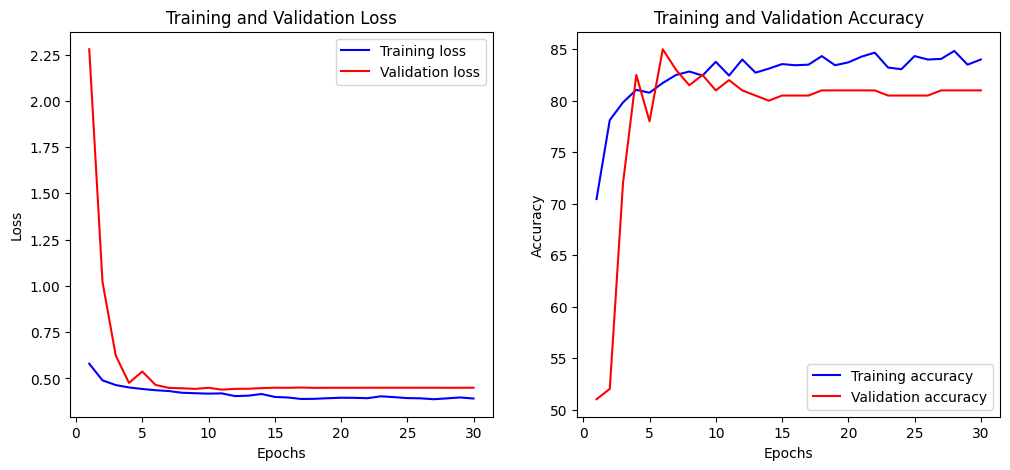

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

channels = 8
height = 125
width = 125

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pretrained_autoencoder = Transformer(
    in_channels=channels,
    num_encoder_layers=2,
    num_decoder_layers=2,
    num_features=height,
    hidden_size=64,
    num_heads=4,
    max_seq_len=height,
    degree=3,
    device=device
).to(device)

# Load the pretrained weights
pretrained_autoencoder.load_state_dict(torch.load('pretrained_transformer.pth'))

pretrained_encoders = nn.ModuleList([encoder for encoder in pretrained_autoencoder.encoders])

# Define the LinearProbe model
class LinearProbe(nn.Module):
    def __init__(self, in_channels, pretrained_encoders, hidden_dim, num_classes):
        super().__init__()
        self.pretrained_encoders = pretrained_encoders
        self.in_channels = in_channels
        self.hidden_dim = hidden_dim

        # Freeze the encoder parameters
        for encoder in self.pretrained_encoders:
            for param in encoder.parameters():
                param.requires_grad = False

        self.flatten_dim = hidden_dim * in_channels
        self.batchnorm = nn.BatchNorm1d(self.flatten_dim, momentum=0.01)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.flatten_dim, num_classes)

    def forward(self, x):
        channels = x.chunk(self.in_channels, dim=1)
        outputs = []
        for enc, channel in zip(self.pretrained_encoders, channels):
            channel = channel.squeeze(1)
            enc_output = enc(channel)
            summed_output = enc_output.sum(dim=1)  # Summing over the sequence length dimension
            outputs.append(summed_output)

        x = torch.cat(outputs, dim=1)  # Concatenate along the channel dimension
        x = self.batchnorm(x)
        x = self.dropout(x)
        return self.linear(x)

def train_linear_probe(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for data, labels in progress_bar:
            data, labels = data.to(device), labels.float().to(device)
            labels = labels.unsqueeze(1) if len(labels.shape) == 1 else labels

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        train_loss /= len(train_loader.dataset)
        train_accuracy = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.float().to(device)
                labels = labels.unsqueeze(1) if len(labels.shape) == 1 else labels

                outputs = model(data)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * data.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        scheduler.step(val_loss)

    return train_losses, val_losses, train_accuracies, val_accuracies

if __name__ == "__main__":
    num_classes = 1

    linear_probe = LinearProbe(channels, pretrained_encoders, hidden_dim=64, num_classes=num_classes).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(linear_probe.parameters(), lr=0.001)

    num_epochs = 30
    train_losses, val_losses, train_accuracies, val_accuracies = train_linear_probe(linear_probe, test_labeled_loader, test_val_loader, criterion, optimizer, num_epochs, device)

    # Plot the learning curves
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
